In [1]:
from os.path import join
from io import StringIO
from collections import defaultdict, OrderedDict

import sympy
from sympy import Symbol, sqrt, cos, pi, symbols
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

import qnet
from qnet.algebra import *

import QDYN

from src.notebook_plots_v1 import plot_bs_decay, display_hamiltonian, display_eq, show_summary_dicke
from src.single_sided_network_v1 import network_slh
from src.dicke_half_model_v2 import write_dicke_half_model, err_dicke_half
from src.qdyn_model_v1 import pulses_uptodate

from doit.tools import register_doit_as_IPython_magic

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
qnet.init_printing()

In [4]:
register_doit_as_IPython_magic()

In [5]:
%run -i module.py

In [6]:
module('load', 'intel/xe2011')
module('load', 'mpi')

$
\newcommand{ket}[1]{\vert #1 \rangle}
\newcommand{bra}[1]{\langle #1 \vert}
\newcommand{Op}[1]{\hat{#1}}
$

# Can we get better results by allowing for complex pulse shapes?

This is a redo of [2017-04-17_mg_dicke_strong_decay_4nodes.ipynb](2017-04-17_mg_dicke_strong_decay_4nodes.ipynb), using pydoit, for direct comparison with [2017-04-27_mg_dicke_4nodes-complex.ipynb](2017-04-27_mg_dicke_4nodes-complex.ipynb)

## action wrappers

In [7]:
def update_config(rf, lambda_a, iter_stop):
    config = QDYN.config.read_config_file(join(rf, 'config'))
    config['oct']['iter_stop'] = iter_stop
    for pulse_config in config['pulse']:
        pulse_config['oct_lambda_a'] = lambda_a
    QDYN.config.write_config(config, join(rf, 'config'))

In [8]:
from src.doit_actions_v1 import run_traj_oct, run_traj_prop, wait_for_oct

## task definitions

In [9]:
def runfolder(row):
    return './data/real/4nodes_kappa1e0_T%d_traj' % row['T']

In [10]:
def runfolders(params_df):
    """Return a list of all the runfolders"""
    rfs = OrderedDict([])
    for ind, row in params_df.iterrows():
        rfs[runfolder(row)] = 1
    return list(rfs.keys())

In [11]:
def task_create_runfolder():
    """Create all necessary runfolders for the runs defined in params_df"""
    jobs = {}
    for ind, row in params_df.iterrows():
        rf = runfolder(row)
        if rf in jobs:
            continue
        jobs[rf] = {
            'name': str(rf),
            'actions': [
                (write_dicke_half_model, [slh,],  dict(
                    rf=rf, T=row['T'], theta=0, nt=500,
                    kappa=1.0, E0_cycles=2, mcwf=True, non_herm=True,
                    lambda_a=row['lambda_a'],
                    iter_stop=int(row['iter_stop']),
                    complex_pulses=False))],
            'targets': [join(rf, 'config')],
            'uptodate': [True, ] # up to date if target exists
        }
    for job in jobs.values():
        yield job

In [12]:
def task_update_runfolder():
    """For every row in params_df, update the config file in the appropriate
    runfolder with the value in that row"""
    rf_jobs = defaultdict(list)
    for ind, row in params_df.iterrows():
        rf = runfolder(row)
        # we only update the config after any earlier optimization has finished
        task_dep = ['wait_for_optimization:%s' % ind2 for ind2 in rf_jobs[rf]]
        rf_jobs[rf].append(ind)
        yield {
            'name': str(ind),
            'actions': [
                (update_config, [], dict(
                    rf=rf, lambda_a=row['lambda_a'],
                    iter_stop=int(row['iter_stop'])))],
            'file_dep': [join(rf, 'config')],
            'uptodate': [False, ],  # always run task
            'task_dep': task_dep}


In [13]:
def task_submit_optimization():
    """Run optimization for every runfolder from params_df"""
    rf_jobs = defaultdict(list)
    for ind, row in params_df.iterrows():
        rf = runfolder(row)
        task_dep = ['wait_for_optimization:%s' % ind2 for ind2 in rf_jobs[rf]]
        task_dep.append('update_runfolder:%s' % ind)
        yield {
            'name': str(ind),
            'actions': [
                (run_traj_oct, [rf, ], dict(n_trajs=row['n_trajs']))],
            'task_dep': task_dep,
            'uptodate': [(pulses_uptodate, [], {'rf': rf}), ],
        }

In [14]:
def task_wait_for_optimization():
    for ind, row in params_df.iterrows():
        rf = runfolder(row)
        yield {
            'name': str(ind),
            'task_dep': ['submit_optimization:%d' % ind],
            'actions': [
                (wait_for_oct, [rf, ], {}),
                'rm -f %s' % join(rf, 'oct.pid')]}

In [15]:
def task_propagate():
    """Run optimization for every runfolder from params_df"""
    jobs = {}
    for ind, row in params_df.iterrows():
        rf = runfolder(row)
        jobs[rf] = {
            'name': str(rf),
            'actions': [
                (run_traj_prop, [rf, ], dict(n_trajs=row['n_trajs']))],
            'file_dep': [join(rf, 'pulse1.oct.dat'),],}
    for job in jobs.values():
        yield job

## Optimization

In [16]:
params_data_str = r'''
#    T  lambda_a  n_trajs   iter_stop
    50     0.001        5        1000
    50    0.0001        5        2000
   100     0.001        5        1000
   200     0.001        5        1000
   500     0.001        5        1000
'''
params_df = pd.read_fwf(
        StringIO(params_data_str), comment='#', header=1,
        names=['T', 'lambda_a', 'n_trajs', 'iter_stop'])

In [17]:
slh = network_slh(n_cavity=2, n_nodes=4, topology='driven_bs_fb')

In [18]:
%doit wait_for_optimization

-- create_runfolder:./data/real/4nodes_kappa1e0_T50_traj
-- create_runfolder:./data/real/4nodes_kappa1e0_T100_traj
-- create_runfolder:./data/real/4nodes_kappa1e0_T200_traj
-- create_runfolder:./data/real/4nodes_kappa1e0_T500_traj
.  update_runfolder:0
.  update_runfolder:2
.  update_runfolder:3
.  update_runfolder:4
-- submit_optimization:0
-- submit_optimization:2
-- submit_optimization:3
-- submit_optimization:4
.  wait_for_optimization:0
.  wait_for_optimization:2
.  wait_for_optimization:3
.  wait_for_optimization:4
.  update_runfolder:1
-- submit_optimization:1
.  wait_for_optimization:1


In [19]:
%doit propagate

.  propagate:./data/real/4nodes_kappa1e0_T50_traj
.  propagate:./data/real/4nodes_kappa1e0_T100_traj
.  propagate:./data/real/4nodes_kappa1e0_T200_traj
.  propagate:./data/real/4nodes_kappa1e0_T500_traj


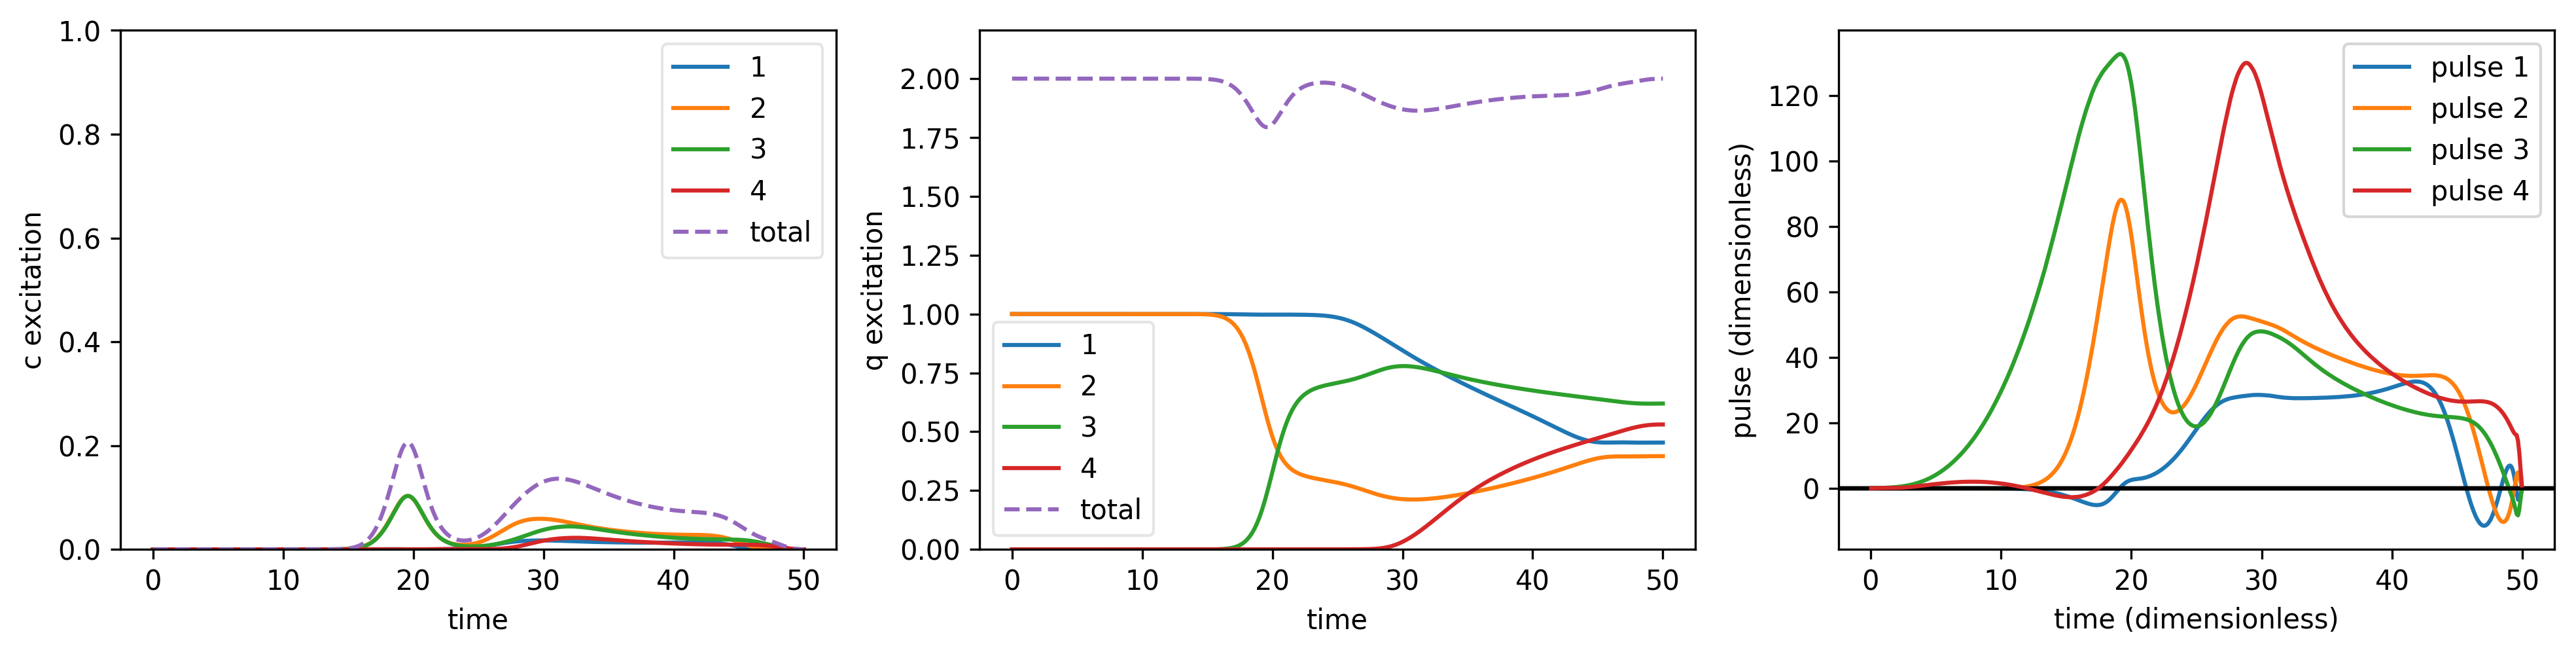

In [20]:
show_summary_dicke('./data/real/4nodes_kappa1e0_T50_traj', dpi=300)